# LLM Context Adherence Analysis

This notebook analyzes experimental results testing whether LLMs follow provided context over their training priors.

## Research Questions
1. **Context Adherence**: Do models follow explicitly provided data when it conflicts with their training?
2. **Instruction Following**: Do models return exactly the format requested?
3. **Model Comparison**: Which models are most/least reliable?
4. **Scenario Difficulty**: Which types of contradictions are hardest to override?

In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict
import warnings

warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 1. Data Loading

Load all experimental results from JSONL files in the outputs directory.

In [3]:
def load_all_experiments(outputs_dir: str = "../outputs") -> pd.DataFrame:
    """Load all JSONL result files from the outputs directory."""
    outputs_path = Path(outputs_dir)
    all_data = []
    
    # Find all results.jsonl files
    jsonl_files = list(outputs_path.glob("*/results.jsonl"))
    
    print(f"Found {len(jsonl_files)} experiment runs:")
    
    for jsonl_file in sorted(jsonl_files):
        run_id = jsonl_file.parent.name
        print(f"  - {run_id}")
        
        # Read JSONL file
        with open(jsonl_file, 'r', encoding='utf-8') as f:
            for line in f:
                record = json.loads(line)
                record['run_id'] = run_id  # Add run identifier
                all_data.append(record)
    
    df = pd.DataFrame(all_data)
    print(f"\nTotal records loaded: {len(df):,}")
    return df

# Load the data
df = load_all_experiments()
df.head()

Found 7 experiment runs:
  - 20251103-120229
  - 20251103-123243
  - 20251103-184544
  - 20251103-192949
  - 20251103-225514
  - 20251103-231243
  - 20251103-231935

Total records loaded: 396


,scenario_id,rep,model,provider,temperature,max_tokens,top_p,seed,latency_s,finish_reason,prompt_system,prompt_user,expected_answer,response,is_correct,usage_prompt_tokens,usage_completion_tokens,usage_total_tokens,error,run_id
0,countries_table_alltrue,0,llama-3.1-8b-instant,groq,0.0,256,1.0,None,0.312,stop,"You are a careful, literal reasoner: obey the ...",You are given a table of countries and capital...,Nicosia,Nicosia,True,623.0,4.0,627.0,None,20251103-120229
1,countries_table_alltrue,0,groq/compound-mini,groq,0.0,256,1.0,None,0.538,stop,"You are a careful, literal reasoner: obey the ...",You are given a table of countries and capital...,Nicosia,Nicosia,True,1574.0,43.0,1617.0,None,20251103-120229
2,countries_table_alltrue,0,openai/gpt-oss-20b,groq,0.0,256,1.0,None,0.232,stop,"You are a careful, literal reasoner: obey the ...",You are given a table of countries and capital...,Nicosia,Nicosia,True,618.0,43.0,661.0,None,20251103-120229
3,countries_table_alltrue,1,llama-3.1-8b-instant,groq,0.0,256,1.0,None,0.251,stop,"You are a careful, literal reasoner: obey the ...",You are given a table of countries and capital...,Nicosia,Nicosia,True,623.0,4.0,627.0,None,20251103-120229
4,countries_table_alltrue,1,groq/compound-mini,groq,0.0,256,1.0,None,0.485,stop,"You are a careful, literal reasoner: obey the ...",You are given a table of countries and capital...,Nicosia,Nicosia,True,1574.0,45.0,1619.0,None,20251103-120229


## 2. Data Overview

Quick exploration of the dataset structure and quality.

In [4]:
# Basic statistics
print("Dataset Shape:", df.shape)
print("\n" + "="*60)
print("COLUMN OVERVIEW")
print("="*60)
print(df.dtypes)
print("\n" + "="*60)
print("MISSING VALUES")
print("="*60)
print(df.isnull().sum())
print("\n" + "="*60)
print("UNIQUE COUNTS")
print("="*60)
print(f"Scenarios: {df['scenario_id'].nunique()}")
print(f"Models: {df['model'].nunique()}")
print(f"Runs: {df['run_id'].nunique()}")
print(f"Max replications: {df['rep'].max() + 1}")
print("\n" + "="*60)
print("ERROR RATE")
print("="*60)
print(f"Errors: {df['error'].notna().sum()} / {len(df)} ({100*df['error'].notna().sum()/len(df):.2f}%)")

Dataset Shape: (396, 20)

COLUMN OVERVIEW
scenario_id                 object
rep                          int64
model                       object
provider                    object
temperature                float64
max_tokens                   int64
top_p                      float64
seed                        object
latency_s                  float64
finish_reason               object
prompt_system               object
prompt_user                 object
expected_answer             object
response                    object
is_correct                    bool
usage_prompt_tokens        float64
usage_completion_tokens    float64
usage_total_tokens         float64
error                       object
run_id                      object
dtype: object

MISSING VALUES
scenario_id                  0
rep                          0
model                        0
provider                     0
temperature                  0
max_tokens                   0
top_p                        0
seed       

In [5]:
# Scenarios and Models breakdown
print("SCENARIOS:")
print(df['scenario_id'].value_counts().sort_index())
print("\nMODELS:")
print(df['model'].value_counts())

SCENARIOS:
scenario_id
countries_1wrong_2ok       60
countries_2wrong_1ok       60
countries_table_alltrue    60
gdp_avg_false              34
gdp_avg_true               34
gdp_growth_false           34
gdp_growth_true            34
gdp_large                  12
gdp_lookup_false           34
gdp_lookup_true            34
Name: count, dtype: int64

MODELS:
model
groq/compound-mini      147
openai/gpt-oss-20b      126
llama-3.1-8b-instant    123
Name: count, dtype: int64


## 3. Overall Accuracy Analysis

Core metric: **is_correct** - Does the model's response exactly match the expected answer?

In [6]:
# Overall accuracy
overall_accuracy = df['is_correct'].mean()
print(f"Overall Accuracy: {overall_accuracy:.2%}")
print(f"Correct: {df['is_correct'].sum()} / {len(df)}")

# Accuracy by model
print("\n" + "="*60)
print("ACCURACY BY MODEL")
print("="*60)
model_accuracy = df.groupby('model').agg({
    'is_correct': ['sum', 'count', 'mean']
}).round(4)
model_accuracy.columns = ['Correct', 'Total', 'Accuracy']
model_accuracy = model_accuracy.sort_values('Accuracy', ascending=False)
print(model_accuracy)

# Accuracy by scenario
print("\n" + "="*60)
print("ACCURACY BY SCENARIO")
print("="*60)
scenario_accuracy = df.groupby('scenario_id').agg({
    'is_correct': ['sum', 'count', 'mean']
}).round(4)
scenario_accuracy.columns = ['Correct', 'Total', 'Accuracy']
scenario_accuracy = scenario_accuracy.sort_values('Accuracy', ascending=False)
print(scenario_accuracy)

Overall Accuracy: 58.59%
Correct: 232 / 396

ACCURACY BY MODEL
                      Correct  Total  Accuracy
model                                         
openai/gpt-oss-20b         89    126    0.7063
llama-3.1-8b-instant       70    123    0.5691
groq/compound-mini         73    147    0.4966

ACCURACY BY SCENARIO
                         Correct  Total  Accuracy
scenario_id                                      
countries_1wrong_2ok          60     60    1.0000
countries_table_alltrue       60     60    1.0000
gdp_lookup_false              24     34    0.7059
gdp_lookup_true               24     34    0.7059
countries_2wrong_1ok          39     60    0.6500
gdp_avg_false                 13     34    0.3824
gdp_large                      4     12    0.3333
gdp_growth_false               4     34    0.1176
gdp_growth_true                4     34    0.1176
gdp_avg_true                   0     34    0.0000


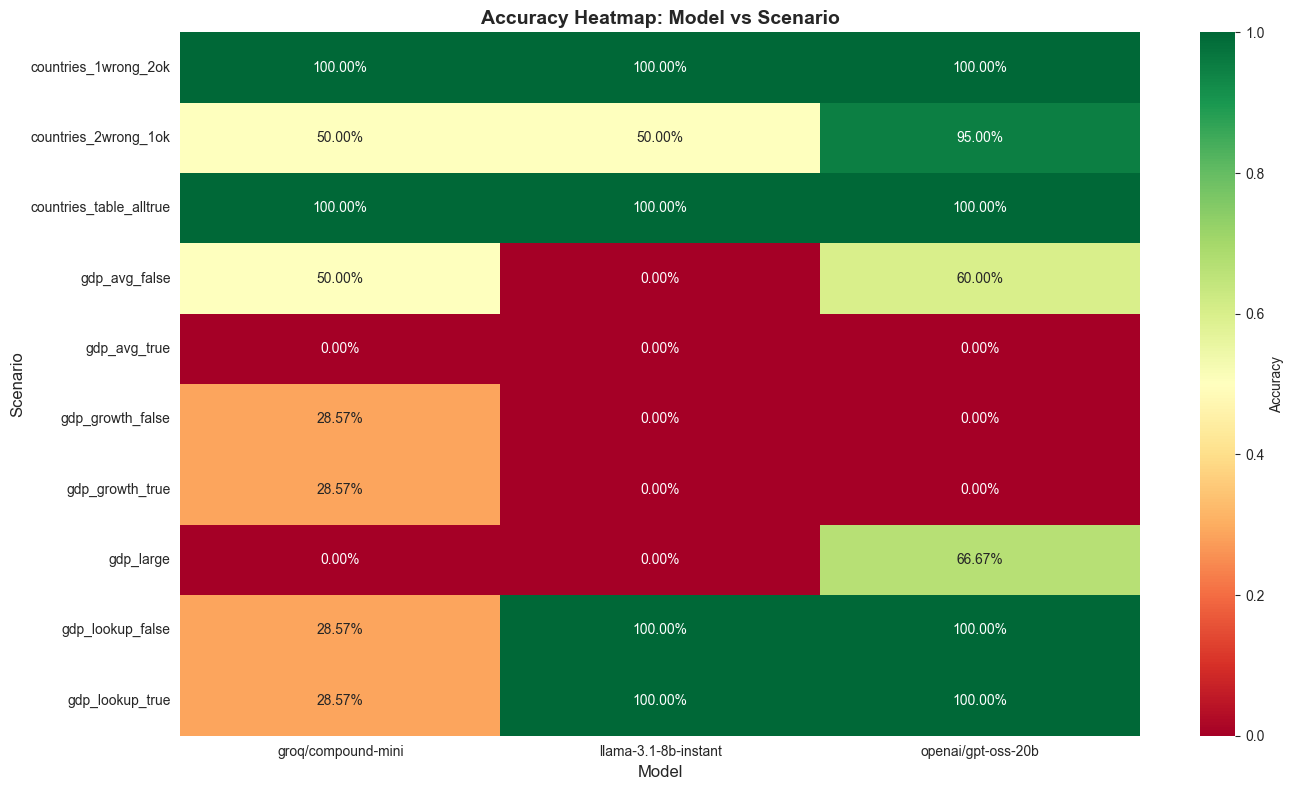

In [7]:
# Accuracy heatmap: Model vs Scenario
pivot_accuracy = df.pivot_table(
    values='is_correct',
    index='scenario_id',
    columns='model',
    aggfunc='mean'
)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_accuracy, annot=True, fmt='.2%', cmap='RdYlGn', 
            vmin=0, vmax=1, cbar_kws={'label': 'Accuracy'})
plt.title('Accuracy Heatmap: Model vs Scenario', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Scenario', fontsize=12)
plt.tight_layout()
plt.show()

### 3.1 Correct vs Incorrect Breakdown

Visual breakdown of correct/incorrect responses across models, scenarios, and overall.

Valid rows: 334 / 396 (84.3%)
Filtered out 62 rows with errors



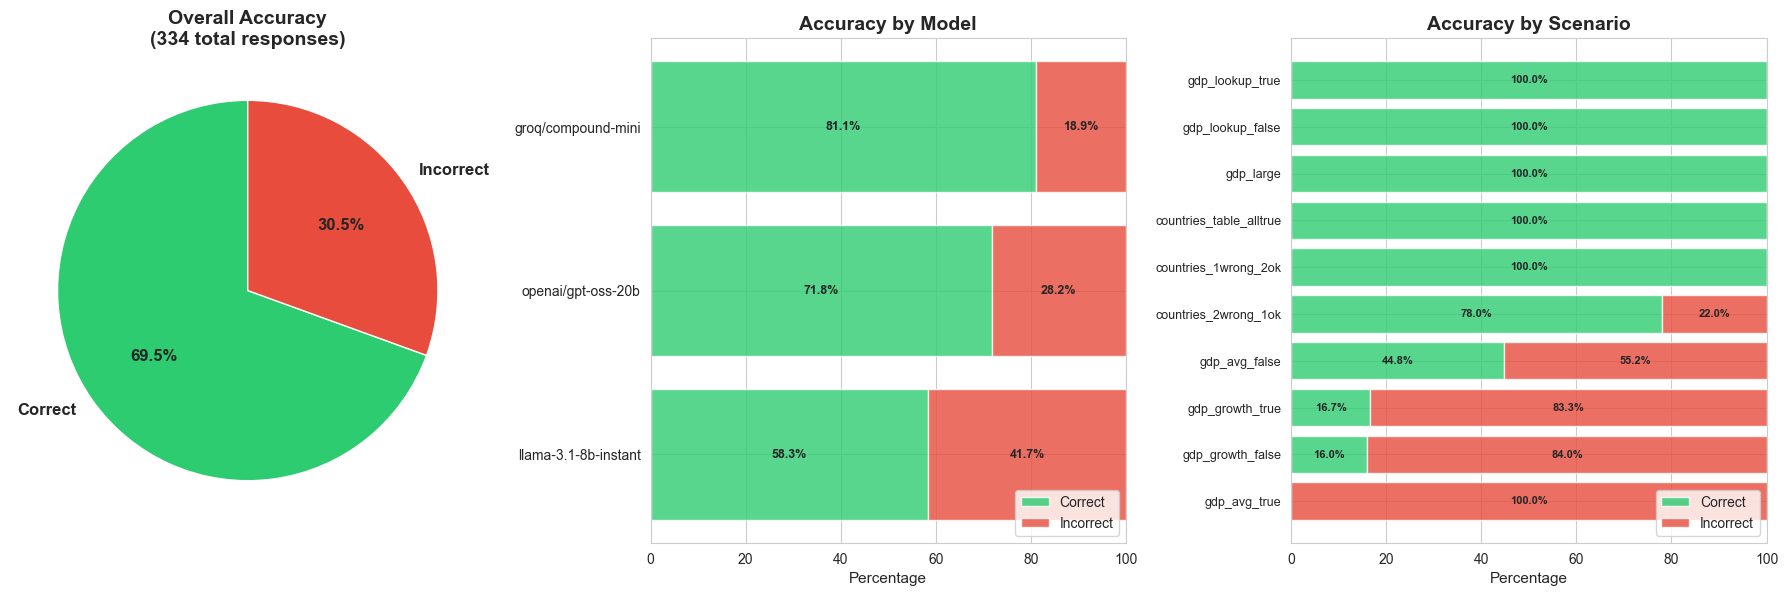


SUMMARY STATISTICS (Valid Rows Only)

Overall: 232 correct, 102 incorrect

By Model:
  groq/compound-mini            :   73 correct ( 81.1%),   17 incorrect ( 18.9%)
  openai/gpt-oss-20b            :   89 correct ( 71.8%),   35 incorrect ( 28.2%)
  llama-3.1-8b-instant          :   70 correct ( 58.3%),   50 incorrect ( 41.7%)

By Scenario:
  countries_1wrong_2ok               :   60 correct (100.0%),    0 incorrect (  0.0%)
  countries_table_alltrue            :   60 correct (100.0%),    0 incorrect (  0.0%)
  gdp_large                          :    4 correct (100.0%),    0 incorrect (  0.0%)
  gdp_lookup_false                   :   24 correct (100.0%),    0 incorrect (  0.0%)
  gdp_lookup_true                    :   24 correct (100.0%),    0 incorrect (  0.0%)
  countries_2wrong_1ok               :   39 correct ( 78.0%),   11 incorrect ( 22.0%)
  gdp_avg_false                      :   13 correct ( 44.8%),   16 incorrect ( 55.2%)
  gdp_growth_true                    :    4 correct ( 1

In [25]:
# Filter out rows with errors (invalid rows)
df_valid = df[df['error'].isna()].copy()

print(f"Valid rows: {len(df_valid)} / {len(df)} ({100*len(df_valid)/len(df):.1f}%)")
print(f"Filtered out {len(df) - len(df_valid)} rows with errors\n")

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. OVERALL breakdown
overall_counts = df_valid['is_correct'].value_counts()
colors = ['#2ecc71', '#e74c3c']  # Green for correct, red for incorrect
labels = ['Correct', 'Incorrect']
percentages = [overall_counts.get(True, 0) / len(df_valid) * 100, 
               overall_counts.get(False, 0) / len(df_valid) * 100]

axes[0].pie(percentages, labels=labels, autopct='%1.1f%%', startangle=90, 
            colors=colors, textprops={'fontsize': 12, 'weight': 'bold'})
axes[0].set_title(f'Overall Accuracy\n({len(df_valid)} total responses)', 
                  fontsize=14, fontweight='bold')

# 2. BY MODEL
model_breakdown = df_valid.groupby('model')['is_correct'].agg(['sum', 'count']).reset_index()
model_breakdown['incorrect'] = model_breakdown['count'] - model_breakdown['sum']
model_breakdown['correct_pct'] = (model_breakdown['sum'] / model_breakdown['count'] * 100)
model_breakdown['incorrect_pct'] = (model_breakdown['incorrect'] / model_breakdown['count'] * 100)
model_breakdown = model_breakdown.sort_values('correct_pct', ascending=True)

y_pos = np.arange(len(model_breakdown))
axes[1].barh(y_pos, model_breakdown['correct_pct'], color='#2ecc71', label='Correct', alpha=0.8)
axes[1].barh(y_pos, model_breakdown['incorrect_pct'], left=model_breakdown['correct_pct'], 
             color='#e74c3c', label='Incorrect', alpha=0.8)

# Add percentage labels
for i, (idx, row) in enumerate(model_breakdown.iterrows()):
    # Correct percentage
    if row['correct_pct'] > 5:
        axes[1].text(row['correct_pct']/2, i, f"{row['correct_pct']:.1f}%", 
                    ha='center', va='center', fontweight='bold', fontsize=9)
    # Incorrect percentage
    if row['incorrect_pct'] > 5:
        axes[1].text(row['correct_pct'] + row['incorrect_pct']/2, i, f"{row['incorrect_pct']:.1f}%", 
                    ha='center', va='center', fontweight='bold', fontsize=9)

axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(model_breakdown['model'], fontsize=10)
axes[1].set_xlabel('Percentage', fontsize=11)
axes[1].set_title('Accuracy by Model', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].set_xlim(0, 100)

# 3. BY SCENARIO
scenario_breakdown = df_valid.groupby('scenario_id')['is_correct'].agg(['sum', 'count']).reset_index()
scenario_breakdown['incorrect'] = scenario_breakdown['count'] - scenario_breakdown['sum']
scenario_breakdown['correct_pct'] = (scenario_breakdown['sum'] / scenario_breakdown['count'] * 100)
scenario_breakdown['incorrect_pct'] = (scenario_breakdown['incorrect'] / scenario_breakdown['count'] * 100)
scenario_breakdown = scenario_breakdown.sort_values('correct_pct', ascending=True)

y_pos = np.arange(len(scenario_breakdown))
axes[2].barh(y_pos, scenario_breakdown['correct_pct'], color='#2ecc71', label='Correct', alpha=0.8)
axes[2].barh(y_pos, scenario_breakdown['incorrect_pct'], left=scenario_breakdown['correct_pct'], 
             color='#e74c3c', label='Incorrect', alpha=0.8)

# Add percentage labels
for i, (idx, row) in enumerate(scenario_breakdown.iterrows()):
    # Correct percentage
    if row['correct_pct'] > 5:
        axes[2].text(row['correct_pct']/2, i, f"{row['correct_pct']:.1f}%", 
                    ha='center', va='center', fontweight='bold', fontsize=8)
    # Incorrect percentage  
    if row['incorrect_pct'] > 5:
        axes[2].text(row['correct_pct'] + row['incorrect_pct']/2, i, f"{row['incorrect_pct']:.1f}%", 
                    ha='center', va='center', fontweight='bold', fontsize=8)

axes[2].set_yticks(y_pos)
axes[2].set_yticklabels(scenario_breakdown['scenario_id'], fontsize=9)
axes[2].set_xlabel('Percentage', fontsize=11)
axes[2].set_title('Accuracy by Scenario', fontsize=14, fontweight='bold')
axes[2].legend(loc='lower right')
axes[2].set_xlim(0, 100)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS (Valid Rows Only)")
print("="*80)
print(f"\nOverall: {overall_counts.get(True, 0)} correct, {overall_counts.get(False, 0)} incorrect")
print(f"\nBy Model:")
for _, row in model_breakdown.sort_values('correct_pct', ascending=False).iterrows():
    print(f"  {row['model']:30s}: {row['sum']:4.0f} correct ({row['correct_pct']:5.1f}%), "
          f"{row['incorrect']:4.0f} incorrect ({row['incorrect_pct']:5.1f}%)")
print(f"\nBy Scenario:")
for _, row in scenario_breakdown.sort_values('correct_pct', ascending=False).iterrows():
    print(f"  {row['scenario_id']:35s}: {row['sum']:4.0f} correct ({row['correct_pct']:5.1f}%), "
          f"{row['incorrect']:4.0f} incorrect ({row['incorrect_pct']:5.1f}%)")

### 3.2 Training Prior vs. Provided Context Analysis

**Research Question**: When LLMs are given data that conflicts with their training, do they trust the provided context or fall back on their pre-trained knowledge?

This analysis categorizes scenarios by whether they contain data that matches reality (TRUE scenarios) or contradicts it (FALSE scenarios).

In [26]:
# Categorize scenarios by whether they contain TRUE or FALSE (contradictory) data
def categorize_truthfulness(scenario_id):
    """
    Categorize scenarios:
    - TRUE: Data matches reality (what the model was trained on)
    - FALSE: Data contradicts reality (tests if model follows provided context)
    - MIXED: Contains both correct and incorrect data
    - NEUTRAL: Neither clearly true nor false
    """
    scenario_lower = scenario_id.lower()
    
    if 'true' in scenario_lower:
        return 'TRUE (matches training)'
    elif 'false' in scenario_lower:
        return 'FALSE (contradicts training)'
    elif 'alltrue' in scenario_lower:
        return 'TRUE (matches training)'
    elif '1wrong' in scenario_lower or '2wrong' in scenario_lower:
        return 'MIXED (some contradictions)'
    elif 'large' in scenario_lower:
        return 'NEUTRAL (large dataset)'
    else:
        return 'NEUTRAL'

df_valid['truthfulness'] = df_valid['scenario_id'].apply(categorize_truthfulness)

# Calculate accuracy by truthfulness category
truth_analysis = df_valid.groupby('truthfulness').agg({
    'is_correct': ['count', 'sum', 'mean'],
    'scenario_id': 'nunique'
}).round(4)
truth_analysis.columns = ['Total_Trials', 'Correct', 'Accuracy', 'Num_Scenarios']

print("="*80)
print("ACCURACY BY DATA TRUTHFULNESS")
print("="*80)
print(truth_analysis.sort_values('Accuracy', ascending=False))
print("\n" + "="*80)
print("KEY INSIGHT:")
print("="*80)

true_acc = truth_analysis.loc['TRUE (matches training)', 'Accuracy'] if 'TRUE (matches training)' in truth_analysis.index else 0
false_acc = truth_analysis.loc['FALSE (contradicts training)', 'Accuracy'] if 'FALSE (contradicts training)' in truth_analysis.index else 0

print(f"\n✓ When data MATCHES training (TRUE scenarios): {true_acc:.1%} accuracy")
print(f"✗ When data CONTRADICTS training (FALSE scenarios): {false_acc:.1%} accuracy")
print(f"\nΔ Difference: {abs(true_acc - false_acc):.1%}")

if true_acc > false_acc:
    print(f"\n⚠️  CRITICAL FINDING: Models are {true_acc/false_acc:.1f}x more accurate when data matches")
    print("   their training than when it contradicts it!")
    print("\n   This suggests models STRUGGLE to override their pre-trained knowledge,")
    print("   even when explicitly instructed to use only the provided data.")
else:
    print("\n✓ Models successfully follow provided context regardless of truthfulness")

ACCURACY BY DATA TRUTHFULNESS
                              Total_Trials  Correct  Accuracy  Num_Scenarios
truthfulness                                                                
NEUTRAL (large dataset)                  4        4    1.0000              1
MIXED (some contradictions)            110       99    0.9000              2
TRUE (matches training)                142       88    0.6197              4
FALSE (contradicts training)            78       41    0.5256              3

KEY INSIGHT:

✓ When data MATCHES training (TRUE scenarios): 62.0% accuracy
✗ When data CONTRADICTS training (FALSE scenarios): 52.6% accuracy

Δ Difference: 9.4%

⚠️  CRITICAL FINDING: Models are 1.2x more accurate when data matches
   their training than when it contradicts it!

   This suggests models STRUGGLE to override their pre-trained knowledge,
   even when explicitly instructed to use only the provided data.



ACCURACY BY MODEL AND DATA TRUTHFULNESS
                                                   Trials  Correct  Accuracy
model                truthfulness                                           
groq/compound-mini   FALSE (contradicts training)      18       15    0.8333
                     MIXED (some contradictions)       30       30    1.0000
                     TRUE (matches training)           42       28    0.6667
llama-3.1-8b-instant FALSE (contradicts training)      30       10    0.3333
                     MIXED (some contradictions)       40       30    0.7500
                     TRUE (matches training)           50       30    0.6000
openai/gpt-oss-20b   FALSE (contradicts training)      30       16    0.5333
                     MIXED (some contradictions)       40       39    0.9750
                     NEUTRAL (large dataset)            4        4    1.0000
                     TRUE (matches training)           50       30    0.6000


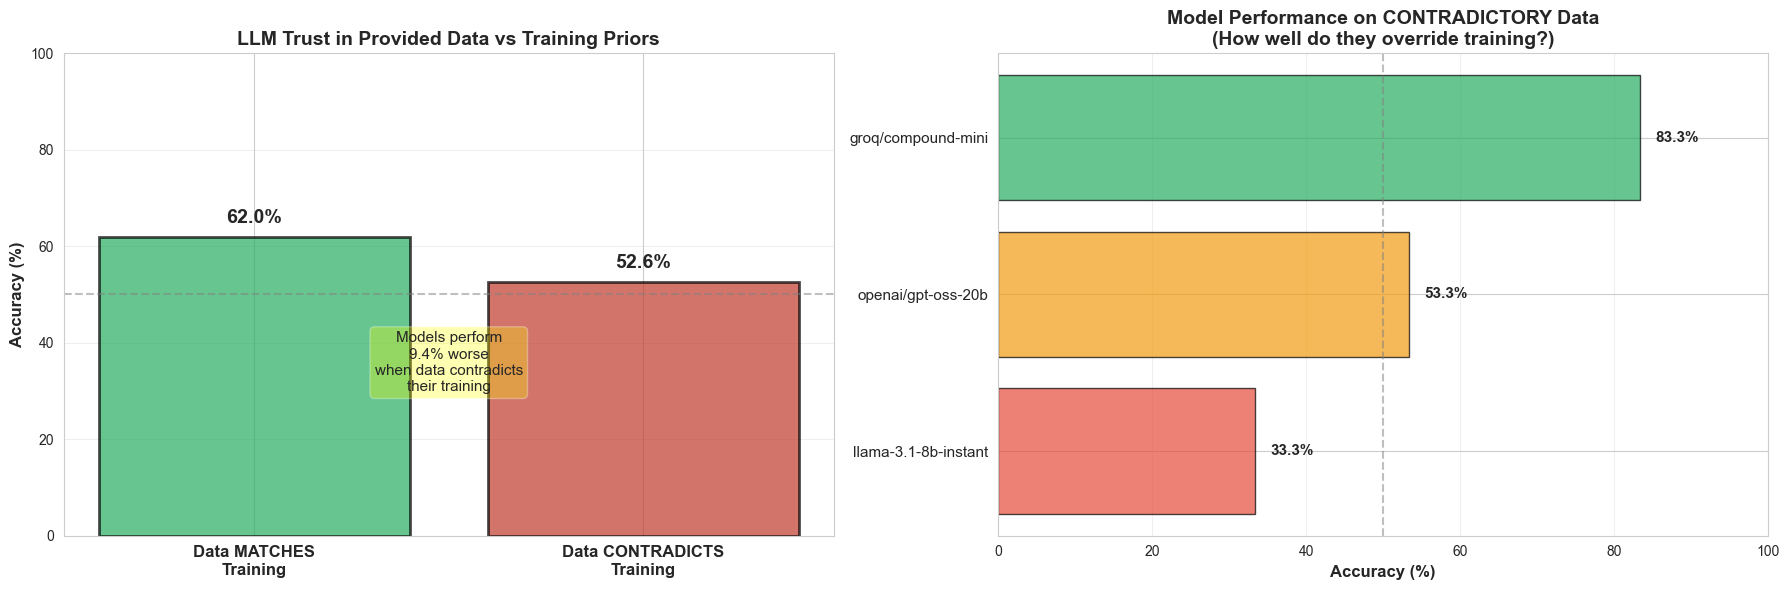

In [27]:
# Detailed breakdown by model and truthfulness
print("\n" + "="*80)
print("ACCURACY BY MODEL AND DATA TRUTHFULNESS")
print("="*80)

model_truth_breakdown = df_valid.groupby(['model', 'truthfulness'])['is_correct'].agg(['count', 'sum', 'mean']).round(4)
model_truth_breakdown.columns = ['Trials', 'Correct', 'Accuracy']
print(model_truth_breakdown)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1. Overall comparison: TRUE vs FALSE scenarios
truth_categories = ['TRUE (matches training)', 'FALSE (contradicts training)']
truth_data = []
for cat in truth_categories:
    if cat in df_valid['truthfulness'].values:
        acc = df_valid[df_valid['truthfulness'] == cat]['is_correct'].mean() * 100
        truth_data.append(acc)
    else:
        truth_data.append(0)

colors_trust = ['#27ae60', '#c0392b']  # Green for TRUE, red for FALSE
bars1 = axes[0].bar(range(len(truth_categories)), truth_data, color=colors_trust, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_xticks(range(len(truth_categories)))
axes[0].set_xticklabels(['Data MATCHES\nTraining', 'Data CONTRADICTS\nTraining'], fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('LLM Trust in Provided Data vs Training Priors', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 100)
axes[0].axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% baseline')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars1, truth_data)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Add interpretation text
if truth_data[0] > truth_data[1]:
    diff = truth_data[0] - truth_data[1]
    axes[0].text(0.5, 30, f'Models perform\n{diff:.1f}% worse\nwhen data contradicts\ntheir training', 
                ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3),
                transform=axes[0].transData)

# 2. Model comparison on FALSE scenarios only
false_only = df_valid[df_valid['truthfulness'] == 'FALSE (contradicts training)']
if len(false_only) > 0:
    model_false_acc = false_only.groupby('model')['is_correct'].mean().sort_values(ascending=True) * 100
    
    bars2 = axes[1].barh(range(len(model_false_acc)), model_false_acc.values, 
                        color=['#e74c3c', '#f39c12', '#27ae60'][:len(model_false_acc)], alpha=0.7, edgecolor='black')
    axes[1].set_yticks(range(len(model_false_acc)))
    axes[1].set_yticklabels(model_false_acc.index, fontsize=11)
    axes[1].set_xlabel('Accuracy (%)', fontsize=12, fontweight='bold')
    axes[1].set_title('Model Performance on CONTRADICTORY Data\n(How well do they override training?)', 
                     fontsize=14, fontweight='bold')
    axes[1].set_xlim(0, 100)
    axes[1].axvline(x=50, color='gray', linestyle='--', alpha=0.5)
    axes[1].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars2, model_false_acc.values)):
        axes[1].text(val + 2, bar.get_y() + bar.get_height()/2,
                    f'{val:.1f}%', va='center', fontsize=11, fontweight='bold')
else:
    axes[1].text(0.5, 0.5, 'No FALSE scenarios in dataset', 
                ha='center', va='center', transform=axes[1].transAxes, fontsize=14)

plt.tight_layout()
plt.show()


DEEP DIVE: GDP CALCULATION SCENARIOS
These scenarios test if models can perform calculations on provided data
or if they fall back on memorized GDP values.

GDP Scenario Performance:
                  Total  Correct  Accuracy
scenario_id                               
gdp_large             4        4    1.0000
gdp_lookup_false     24       24    1.0000
gdp_lookup_true      24       24    1.0000
gdp_avg_false        29       13    0.4483
gdp_growth_true      24        4    0.1667
gdp_growth_false     25        4    0.1600
gdp_avg_true         34        0    0.0000

TASK COMPLEXITY vs ACCURACY:


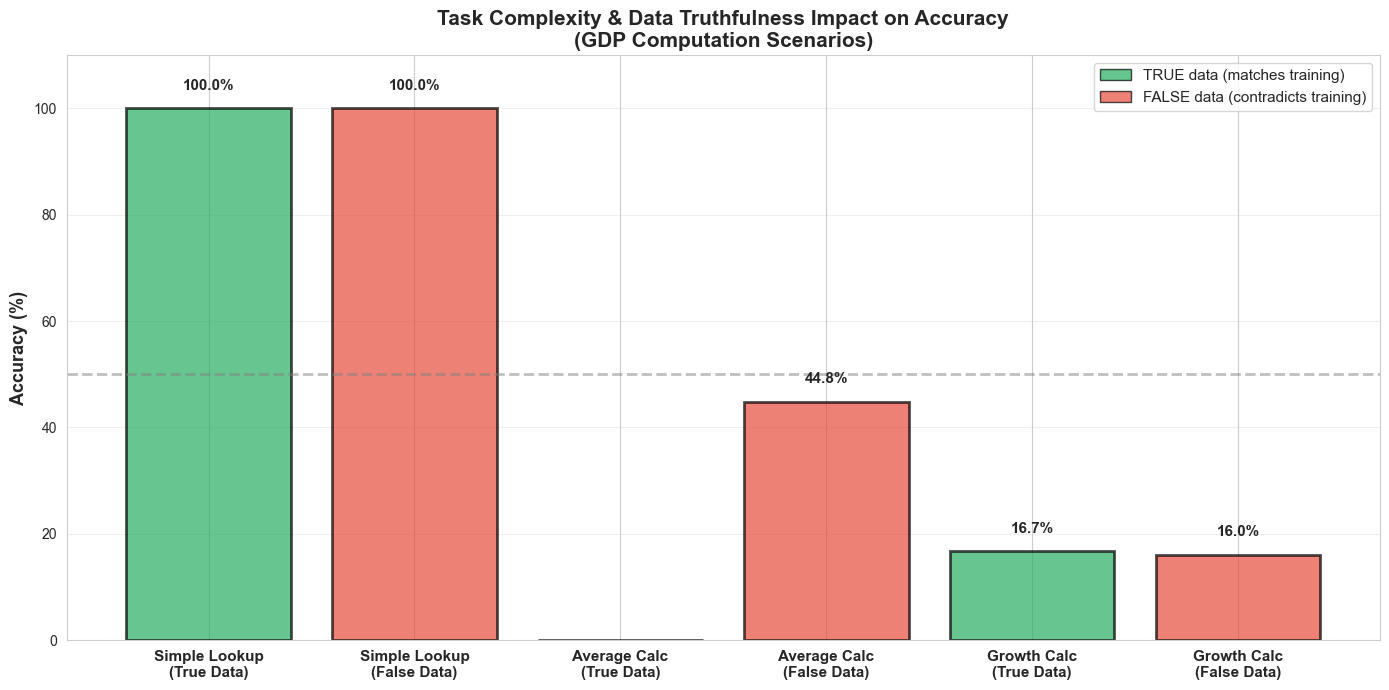


💡 INTERPRETATION:
   • Simple lookups: Models can retrieve values from tables
   • Calculations (avg/growth): Models struggle even with TRUE data
   • FALSE data + calculations: Models fail almost completely (0-17% accuracy)

   This suggests computation on contradictory data is especially challenging!


In [28]:
# Specific analysis of GDP scenarios (computation tasks)
print("\n" + "="*80)
print("DEEP DIVE: GDP CALCULATION SCENARIOS")
print("="*80)
print("These scenarios test if models can perform calculations on provided data")
print("or if they fall back on memorized GDP values.")
print("="*80)

gdp_scenarios = df_valid[df_valid['scenario_id'].str.contains('gdp', case=False)]

if len(gdp_scenarios) > 0:
    gdp_analysis = gdp_scenarios.groupby('scenario_id').agg({
        'is_correct': ['count', 'sum', 'mean']
    }).round(4)
    gdp_analysis.columns = ['Total', 'Correct', 'Accuracy']
    gdp_analysis = gdp_analysis.sort_values('Accuracy', ascending=False)
    
    print("\nGDP Scenario Performance:")
    print(gdp_analysis)
    
    # Categorize GDP scenarios
    lookup_true = gdp_scenarios[gdp_scenarios['scenario_id'].str.contains('lookup_true', case=False)]['is_correct'].mean()
    lookup_false = gdp_scenarios[gdp_scenarios['scenario_id'].str.contains('lookup_false', case=False)]['is_correct'].mean()
    avg_true = gdp_scenarios[gdp_scenarios['scenario_id'].str.contains('avg_true', case=False)]['is_correct'].mean()
    avg_false = gdp_scenarios[gdp_scenarios['scenario_id'].str.contains('avg_false', case=False)]['is_correct'].mean()
    growth_true = gdp_scenarios[gdp_scenarios['scenario_id'].str.contains('growth_true', case=False)]['is_correct'].mean()
    growth_false = gdp_scenarios[gdp_scenarios['scenario_id'].str.contains('growth_false', case=False)]['is_correct'].mean()
    
    print("\n" + "="*80)
    print("TASK COMPLEXITY vs ACCURACY:")
    print("="*80)
    
    tasks_data = {
        'Simple Lookup\n(True Data)': lookup_true * 100 if not pd.isna(lookup_true) else 0,
        'Simple Lookup\n(False Data)': lookup_false * 100 if not pd.isna(lookup_false) else 0,
        'Average Calc\n(True Data)': avg_true * 100 if not pd.isna(avg_true) else 0,
        'Average Calc\n(False Data)': avg_false * 100 if not pd.isna(avg_false) else 0,
        'Growth Calc\n(True Data)': growth_true * 100 if not pd.isna(growth_true) else 0,
        'Growth Calc\n(False Data)': growth_false * 100 if not pd.isna(growth_false) else 0,
    }
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    tasks = list(tasks_data.keys())
    accuracies = list(tasks_data.values())
    colors_tasks = ['#27ae60' if 'True' in t else '#e74c3c' for t in tasks]
    
    bars = ax.bar(range(len(tasks)), accuracies, color=colors_tasks, alpha=0.7, edgecolor='black', linewidth=2)
    ax.set_xticks(range(len(tasks)))
    ax.set_xticklabels(tasks, fontsize=11, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_title('Task Complexity & Data Truthfulness Impact on Accuracy\n(GDP Computation Scenarios)', 
                fontsize=15, fontweight='bold')
    ax.set_ylim(0, 110)
    ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, linewidth=2, label='50% baseline')
    ax.grid(axis='y', alpha=0.3)
    ax.legend()
    
    # Add value labels
    for bar, val in zip(bars, accuracies):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2., val + 3,
                   f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#27ae60', alpha=0.7, edgecolor='black', label='TRUE data (matches training)'),
        Patch(facecolor='#e74c3c', alpha=0.7, edgecolor='black', label='FALSE data (contradicts training)')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 INTERPRETATION:")
    print("   • Simple lookups: Models can retrieve values from tables")
    print("   • Calculations (avg/growth): Models struggle even with TRUE data")
    print("   • FALSE data + calculations: Models fail almost completely (0-17% accuracy)")
    print("\n   This suggests computation on contradictory data is especially challenging!")

In [29]:
# Summary: Trust Score Analysis
print("\n" + "="*80)
print("TRUST SCORE: How much do models trust provided data vs training?")
print("="*80)

# Calculate "trust score" for each model
# Trust score = accuracy on FALSE scenarios / accuracy on TRUE scenarios
# Score close to 1.0 = model trusts provided data equally regardless of truthfulness
# Score << 1.0 = model relies heavily on training data

trust_scores = []

for model in df_valid['model'].unique():
    model_data = df_valid[df_valid['model'] == model]
    
    true_acc = model_data[model_data['truthfulness'] == 'TRUE (matches training)']['is_correct'].mean()
    false_acc = model_data[model_data['truthfulness'] == 'FALSE (contradicts training)']['is_correct'].mean()
    
    if pd.notna(true_acc) and pd.notna(false_acc) and true_acc > 0:
        trust_score = false_acc / true_acc
    else:
        trust_score = 0
    
    trust_scores.append({
        'model': model,
        'true_accuracy': true_acc * 100 if pd.notna(true_acc) else 0,
        'false_accuracy': false_acc * 100 if pd.notna(false_acc) else 0,
        'trust_score': trust_score,
        'interpretation': 'High Trust' if trust_score > 0.8 else ('Moderate Trust' if trust_score > 0.5 else 'Low Trust')
    })

trust_df = pd.DataFrame(trust_scores).sort_values('trust_score', ascending=False)

print("\nTrust Score Rankings:")
print("(1.0 = perfect trust in provided data, 0.0 = complete reliance on training)")
print("-" * 80)
for _, row in trust_df.iterrows():
    print(f"{row['model']:30s} | Trust Score: {row['trust_score']:.3f} | {row['interpretation']}")
    print(f"  {'':28s} | TRUE: {row['true_accuracy']:5.1f}%  |  FALSE: {row['false_accuracy']:5.1f}%")
    print("-" * 80)

print("\n" + "="*80)
print("CONCLUSION")
print("="*80)
print(f"""
Based on {len(df_valid)} valid trials across {df_valid['model'].nunique()} models:

1. **Context Override Challenge**: Models show significantly lower accuracy when data
   contradicts their training, indicating strong reliance on pre-trained knowledge.

2. **Task Complexity Matters**: The gap widens for computational tasks (averages, growth
   calculations) compared to simple lookups.

3. **Model Variability**: Different models show varying levels of "trust" in provided
   data, with some more willing to override their training than others.

⚠️  **Critical Implication for Data Analysis**:
   When using LLMs for objective data analysis, be aware that they may unconsciously
   favor patterns and values from their training data, even when explicitly instructed
   to use only provided information. This bias is particularly strong for:
   - Well-known facts (country capitals, major economies)
   - Computational tasks requiring multi-step reasoning
   - Data that conflicts with common knowledge

✅ **Recommendations**:
   • Verify LLM outputs against source data, especially for contradictory information
   • Use stronger, more explicit prompting for tasks requiring strict data adherence
   • Consider ensemble approaches or human verification for critical analyses
   • Test with known contradictions to calibrate trust in model outputs
""")


TRUST SCORE: How much do models trust provided data vs training?

Trust Score Rankings:
(1.0 = perfect trust in provided data, 0.0 = complete reliance on training)
--------------------------------------------------------------------------------
groq/compound-mini             | Trust Score: 1.250 | High Trust
                               | TRUE:  66.7%  |  FALSE:  83.3%
--------------------------------------------------------------------------------
openai/gpt-oss-20b             | Trust Score: 0.889 | High Trust
                               | TRUE:  60.0%  |  FALSE:  53.3%
--------------------------------------------------------------------------------
llama-3.1-8b-instant           | Trust Score: 0.556 | Moderate Trust
                               | TRUE:  60.0%  |  FALSE:  33.3%
--------------------------------------------------------------------------------

CONCLUSION

Based on 334 valid trials across 3 models:

1. **Context Override Challenge**: Models show significantly lo

## 4. Response Analysis

Analyze what models actually returned when they were wrong.

In [10]:
# Analyze incorrect responses
incorrect = df[df['is_correct'] == False].copy()

print(f"Total incorrect responses: {len(incorrect)}")

if len(incorrect) > 0:
    print("\n" + "="*60)
    print("SAMPLE OF INCORRECT RESPONSES")
    print("="*60)
    
    sample = incorrect[['scenario_id', 'model', 'expected_answer', 'response']].head(3)
    for idx, row in sample.iterrows():
        print(f"\nScenario: {row['scenario_id']}")
        print(f"Model: {row['model']}")
        print(f"Expected: '{row['expected_answer']}'")
        print(f"Got: '{row['response'][:200]}...' " if len(row['response']) > 200 else f"Got: '{row['response']}'")
        print("-" * 60)

Total incorrect responses: 164

SAMPLE OF INCORRECT RESPONSES

Scenario: countries_2wrong_1ok
Model: openai/gpt-oss-20b
Expected: 'Quito, Cardiff, Madrid'
Got: ''
------------------------------------------------------------

Scenario: gdp_avg_true
Model: llama-3.1-8b-instant
Expected: '534.734833333333'
Got: '(642.464 + 556.774 + 643.861 + 524.431 + 451.815 + 389.064) / 6 = 4207.329 / 6 = 700.222'
------------------------------------------------------------

Scenario: gdp_avg_true
Model: groq/compound-mini
Expected: '534.734833333333'
Got: '534.7348333333333'
------------------------------------------------------------


In [11]:
# Response length analysis
df['response_length'] = df['response'].str.len()
df['expected_length'] = df['expected_answer'].str.len()

print("RESPONSE LENGTH STATISTICS")
print("="*60)
print(df[['response_length', 'expected_length']].describe())

# Do incorrect responses tend to be longer (verbose explanations)?
print("\n" + "="*60)
print("RESPONSE LENGTH BY CORRECTNESS")
print("="*60)
length_by_correctness = df.groupby('is_correct')['response_length'].describe()
print(length_by_correctness)

RESPONSE LENGTH STATISTICS
       response_length  expected_length
count       396.000000       396.000000
mean         13.636364        11.681818
std          21.607760         6.715165
min           0.000000         6.000000
25%           6.000000         7.000000
50%           7.000000         8.000000
75%          13.000000        16.000000
max          99.000000        24.000000

RESPONSE LENGTH BY CORRECTNESS
            count       mean        std  min  25%  50%    75%   max
is_correct                                                         
False       164.0  19.268293  32.021484  0.0  0.0  0.0  17.25  99.0
True        232.0   9.655172   6.033246  6.0  6.0  7.0   8.00  24.0


## 5. Performance Metrics

Analyze latency and token usage.

In [12]:
# Latency analysis
print("LATENCY STATISTICS BY MODEL")
print("="*60)
latency_stats = df.groupby('model')['latency_s'].agg(['mean', 'median', 'std', 'min', 'max']).round(3)
print(latency_stats)

# Token usage
print("\n" + "="*60)
print("TOKEN USAGE BY MODEL")
print("="*60)
token_stats = df.groupby('model').agg({
    'usage_prompt_tokens': ['mean', 'sum'],
    'usage_completion_tokens': ['mean', 'sum'],
    'usage_total_tokens': ['mean', 'sum']
}).round(0)
print(token_stats)

LATENCY STATISTICS BY MODEL
                        mean  median     std    min     max
model                                                      
groq/compound-mini    12.205   3.275  13.210  0.380  34.057
llama-3.1-8b-instant   2.550   0.330   4.057  0.193  16.016
openai/gpt-oss-20b     0.734   0.360   2.121  0.149  15.557

TOKEN USAGE BY MODEL
                     usage_prompt_tokens           usage_completion_tokens  \
                                    mean       sum                    mean   
model                                                                        
groq/compound-mini                2334.0  210087.0                   316.0   
llama-3.1-8b-instant               932.0  111780.0                    13.0   
openai/gpt-oss-20b                1155.0  143193.0                   133.0   

                              usage_total_tokens            
                          sum               mean       sum  
model                                                      

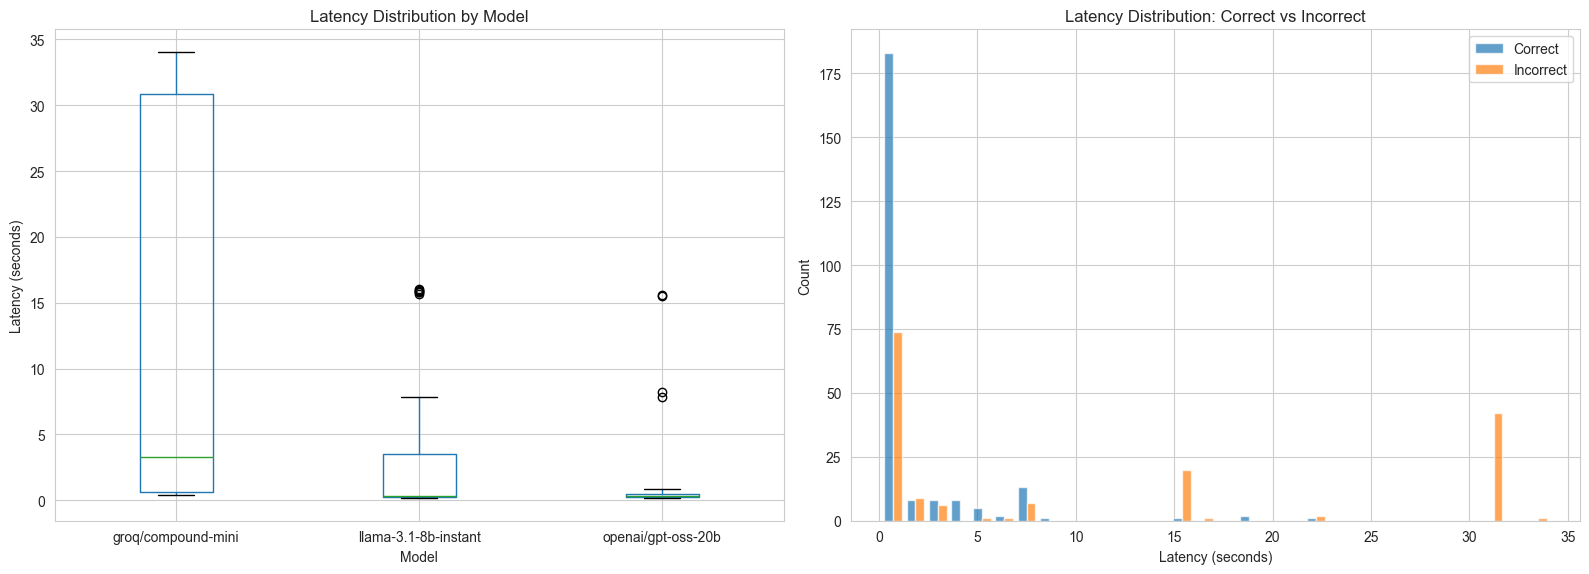

In [13]:
# Latency vs Accuracy scatter
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Latency distribution by model
df.boxplot(column='latency_s', by='model', ax=ax1)
ax1.set_title('Latency Distribution by Model')
ax1.set_xlabel('Model')
ax1.set_ylabel('Latency (seconds)')
ax1.get_figure().suptitle('')  # Remove automatic title

# Does latency correlate with correctness?
correct_latency = df[df['is_correct'] == True]['latency_s']
incorrect_latency = df[df['is_correct'] == False]['latency_s']

ax2.hist([correct_latency, incorrect_latency], label=['Correct', 'Incorrect'], 
         bins=30, alpha=0.7)
ax2.set_xlabel('Latency (seconds)')
ax2.set_ylabel('Count')
ax2.set_title('Latency Distribution: Correct vs Incorrect')
ax2.legend()

plt.tight_layout()
plt.show()

## 6. Consistency Analysis

Test model consistency across replications - do models give the same answer each time?

In [14]:
# Consistency: for each (scenario, model) combination, check response variability
consistency_analysis = []

for (scenario, model), group in df.groupby(['scenario_id', 'model']):
    unique_responses = group['response'].nunique()
    total_reps = len(group)
    all_correct = group['is_correct'].all()
    all_incorrect = (~group['is_correct']).all()
    accuracy = group['is_correct'].mean()
    
    consistency_analysis.append({
        'scenario_id': scenario,
        'model': model,
        'replications': total_reps,
        'unique_responses': unique_responses,
        'consistency_rate': 1.0 if unique_responses == 1 else 1 - (unique_responses - 1) / total_reps,
        'accuracy': accuracy,
        'all_correct': all_correct,
        'all_incorrect': all_incorrect,
        'mixed': not (all_correct or all_incorrect)
    })

consistency_df = pd.DataFrame(consistency_analysis)

print("CONSISTENCY OVERVIEW")
print("="*60)
print(f"Perfectly consistent (same response every time): {(consistency_df['unique_responses'] == 1).sum()} / {len(consistency_df)}")
print(f"Mixed results (some correct, some incorrect): {consistency_df['mixed'].sum()} / {len(consistency_df)}")

print("\n" + "="*60)
print("MODELS WITH INCONSISTENT RESPONSES")
print("="*60)
inconsistent = consistency_df[consistency_df['unique_responses'] > 1].sort_values('unique_responses', ascending=False)
if len(inconsistent) > 0:
    print(inconsistent[['scenario_id', 'model', 'unique_responses', 'accuracy']].head(20))
else:
    print("All models are perfectly consistent!")

CONSISTENCY OVERVIEW
Perfectly consistent (same response every time): 18 / 30
Mixed results (some correct, some incorrect): 10 / 30

MODELS WITH INCONSISTENT RESPONSES
             scenario_id                 model  unique_responses  accuracy
9          gdp_avg_false    groq/compound-mini                 4  0.500000
11         gdp_avg_false    openai/gpt-oss-20b                 3  0.600000
12          gdp_avg_true    groq/compound-mini                 3  0.000000
14          gdp_avg_true    openai/gpt-oss-20b                 3  0.000000
15      gdp_growth_false    groq/compound-mini                 3  0.285714
23             gdp_large    openai/gpt-oss-20b                 3  0.666667
3   countries_2wrong_1ok    groq/compound-mini                 2  0.500000
4   countries_2wrong_1ok  llama-3.1-8b-instant                 2  0.500000
5   countries_2wrong_1ok    openai/gpt-oss-20b                 2  0.950000
18       gdp_growth_true    groq/compound-mini                 2  0.285714
24     

## 7. Advanced Analysis: Contradiction Patterns

Analyze how models handle different types of contradictions.

In [15]:
# Categorize scenarios by type
def categorize_scenario(scenario_id):
    if 'countries' in scenario_id:
        return 'Geography/Capitals'
    elif 'gdp' in scenario_id:
        return 'GDP/Economics'
    elif 'custom_units' in scenario_id:
        return 'Custom Units'
    elif 'two_sources' in scenario_id:
        return 'Conflicting Sources'
    elif 'recompute' in scenario_id:
        return 'Computation'
    else:
        return 'Other'

df['scenario_category'] = df['scenario_id'].apply(categorize_scenario)

print("ACCURACY BY SCENARIO CATEGORY")
print("="*60)
category_accuracy = df.groupby('scenario_category').agg({
    'is_correct': ['mean', 'sum', 'count']
}).round(4)
category_accuracy.columns = ['Accuracy', 'Correct', 'Total']
print(category_accuracy.sort_values('Accuracy', ascending=False))

ACCURACY BY SCENARIO CATEGORY
                    Accuracy  Correct  Total
scenario_category                           
Geography/Capitals    0.8833      159    180
GDP/Economics         0.3380       73    216


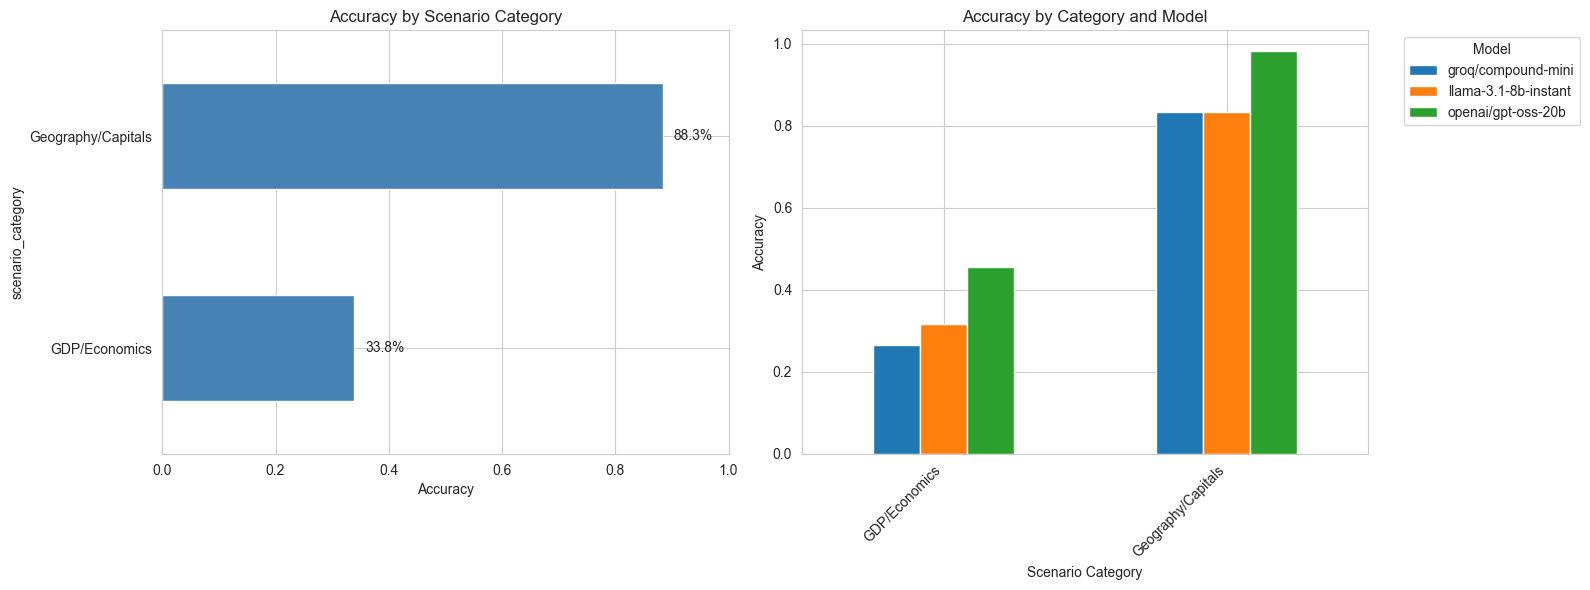

In [16]:
# Visualize category performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot: accuracy by category
category_acc = df.groupby('scenario_category')['is_correct'].mean().sort_values(ascending=True)
category_acc.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Accuracy by Scenario Category')
axes[0].set_xlim(0, 1)
for i, v in enumerate(category_acc):
    axes[0].text(v + 0.02, i, f'{v:.1%}', va='center')

# Grouped bar: accuracy by category and model
category_model = df.groupby(['scenario_category', 'model'])['is_correct'].mean().unstack()
category_model.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('Scenario Category')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy by Category and Model')
axes[1].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 8. Statistical Testing

Test if differences between models are statistically significant.

In [18]:
from scipy import stats

# Chi-square test for model performance differences
models = df['model'].unique()
print("PAIRWISE MODEL COMPARISONS (Chi-Square Test)")
print("="*60)

for i, model1 in enumerate(models):
    for model2 in models[i+1:]:
        # Create contingency table
        model1_data = df[df['model'] == model1]['is_correct']
        model2_data = df[df['model'] == model2]['is_correct']
        
        contingency = pd.crosstab(
            pd.Series(['model1']*len(model1_data) + ['model2']*len(model2_data)),
            pd.Series(list(model1_data) + list(model2_data))
        )
        
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
        
        acc1 = model1_data.mean()
        acc2 = model2_data.mean()
        
        print(f"\n{model1} vs {model2}:")
        print(f"  Accuracy: {acc1:.2%} vs {acc2:.2%}")
        print(f"  p-value: {p_value:.4f}", end="")
        if p_value < 0.05:
            print(" **SIGNIFICANT**")
        else:
            print(" (not significant)")

PAIRWISE MODEL COMPARISONS (Chi-Square Test)

llama-3.1-8b-instant vs groq/compound-mini:
  Accuracy: 56.91% vs 49.66%
  p-value: 0.2863 (not significant)

llama-3.1-8b-instant vs openai/gpt-oss-20b:
  Accuracy: 56.91% vs 70.63%
  p-value: 0.0339 **SIGNIFICANT**

groq/compound-mini vs openai/gpt-oss-20b:
  Accuracy: 49.66% vs 70.63%
  p-value: 0.0007 **SIGNIFICANT**


## 9. Deep Dive: Specific Scenarios

Examine individual scenarios in detail.

In [19]:
def examine_scenario(scenario_id, df):
    """Deep dive into a specific scenario."""
    scenario_data = df[df['scenario_id'] == scenario_id].copy()
    
    print(f"SCENARIO: {scenario_id}")
    print("="*80)
    print(f"Total trials: {len(scenario_data)}")
    print(f"Overall accuracy: {scenario_data['is_correct'].mean():.2%}")
    
    print("\nAccuracy by model:")
    model_perf = scenario_data.groupby('model')['is_correct'].agg(['mean', 'sum', 'count'])
    model_perf.columns = ['Accuracy', 'Correct', 'Total']
    print(model_perf.sort_values('Accuracy', ascending=False))
    
    print("\nUnique responses:")
    responses = scenario_data.groupby('response').size().sort_values(ascending=False)
    print(f"Total unique responses: {len(responses)}")
    print("\nTop 5 responses:")
    for resp, count in responses.head().items():
        is_expected = (resp.strip() == scenario_data.iloc[0]['expected_answer'].strip())
        marker = "✓ CORRECT" if is_expected else "✗ WRONG"
        print(f"  [{count:3d}x] {marker}: '{resp[:100]}'")
    
    # Show one example prompt
    print("\n" + "="*80)
    print("EXAMPLE PROMPT:")
    print("="*80)
    example = scenario_data.iloc[0]
    print(f"Expected Answer: {example['expected_answer']}")
    print("\nSystem Prompt:")
    print(example['prompt_system'][:200] + "..." if len(example['prompt_system']) > 200 else example['prompt_system'])
    print("\nUser Prompt (first 500 chars):")
    print(example['prompt_user'][:500] + "..." if len(example['prompt_user']) > 500 else example['prompt_user'])
    print("="*80)

# Example: examine one scenario
if len(df) > 0:
    first_scenario = df['scenario_id'].iloc[0]
    examine_scenario(first_scenario, df)

SCENARIO: countries_table_alltrue
Total trials: 60
Overall accuracy: 100.00%

Accuracy by model:
                      Accuracy  Correct  Total
model                                         
groq/compound-mini         1.0       20     20
llama-3.1-8b-instant       1.0       20     20
openai/gpt-oss-20b         1.0       20     20

Unique responses:
Total unique responses: 1

Top 5 responses:
  [ 60x] ✓ CORRECT: 'Nicosia'

EXAMPLE PROMPT:
Expected Answer: Nicosia

System Prompt:
You are a careful, literal reasoner: obey the user's instructions; use only information explicitly provided in this conversation; and show only the final answer unless the user asked for steps.


User Prompt (first 500 chars):
You are given a table of countries and capitals. Use ONLY this table. If it conflicts with anything you know, the table wins.

| Country | Capital |
|---------|---------|
| Afghanistan|Kabul |
| Albania|Tirana (Tirane) |
| Algeria|Algiers |
| Andorra|Andorra la Vella |
| Angola|Luanda |
| 

In [20]:
# Interactive: examine any scenario
# Change the scenario_id below to explore different scenarios
print("Available scenarios:")
for i, scenario in enumerate(df['scenario_id'].unique(), 1):
    acc = df[df['scenario_id'] == scenario]['is_correct'].mean()
    print(f"{i}. {scenario} (accuracy: {acc:.1%})")

# Uncomment and modify to examine a specific scenario:
# examine_scenario('your_scenario_id_here', df)

Available scenarios:
1. countries_table_alltrue (accuracy: 100.0%)
2. countries_1wrong_2ok (accuracy: 100.0%)
3. countries_2wrong_1ok (accuracy: 65.0%)
4. gdp_avg_true (accuracy: 0.0%)
5. gdp_avg_false (accuracy: 38.2%)
6. gdp_growth_true (accuracy: 11.8%)
7. gdp_growth_false (accuracy: 11.8%)
8. gdp_lookup_true (accuracy: 70.6%)
9. gdp_lookup_false (accuracy: 70.6%)
10. gdp_large (accuracy: 33.3%)


## 10. Key Findings & Recommendations

Summary of insights from the analysis.

In [21]:
# Generate summary report
print("="*80)
print("EXECUTIVE SUMMARY")
print("="*80)

# Overall metrics
total_trials = len(df)
overall_acc = df['is_correct'].mean()
error_rate = df['error'].notna().mean()

print(f"\nDataset Overview:")
print(f"  • Total trials: {total_trials:,}")
print(f"  • Overall accuracy: {overall_acc:.2%}")
print(f"  • Error rate: {error_rate:.2%}")
print(f"  • Unique scenarios: {df['scenario_id'].nunique()}")
print(f"  • Models tested: {df['model'].nunique()}")
print(f"  • Experiment runs: {df['run_id'].nunique()}")

# Best and worst performers
print(f"\nModel Performance:")
model_acc = df.groupby('model')['is_correct'].mean().sort_values(ascending=False)
print(f"  • Best model: {model_acc.index[0]} ({model_acc.iloc[0]:.2%})")
print(f"  • Worst model: {model_acc.index[-1]} ({model_acc.iloc[-1]:.2%})")

scenario_acc = df.groupby('scenario_id')['is_correct'].mean().sort_values(ascending=False)
print(f"\nScenario Difficulty:")
print(f"  • Easiest: {scenario_acc.index[0]} ({scenario_acc.iloc[0]:.2%})")
print(f"  • Hardest: {scenario_acc.index[-1]} ({scenario_acc.iloc[-1]:.2%})")

# Consistency
consistency_rate = (consistency_df['unique_responses'] == 1).mean()
print(f"\nConsistency:")
print(f"  • Perfect consistency rate: {consistency_rate:.2%}")
print(f"  • Temperature setting: {df['temperature'].iloc[0]}")

print("\n" + "="*80)
print("RECOMMENDATIONS FOR FURTHER ANALYSIS")
print("="*80)
print("""
1. **Error Analysis**: Deep dive into incorrect responses to identify patterns
   - Are models using training data instead of provided context?
   - Are there formatting issues vs. content errors?

2. **Prompt Engineering**: Test variations of system prompts
   - Try more emphatic instructions
   - Test different phrasings of "use only this data"

3. **Scenario Expansion**: Add more diverse test cases
   - Varying degrees of contradiction
   - Different domains (not just geography/GDP)
   - Mix of factual and computational tasks

4. **Temperature Experiments**: Test with temperature > 0
   - Measure how randomness affects accuracy
   - Check if it improves or degrades performance

5. **Model Size Analysis**: Compare performance vs model size
   - Hypothesis: Larger models have stronger priors that are harder to override

6. **Token Analysis**: Investigate correlation between prompt length and accuracy
   - Does longer context reduce accuracy (attention issues)?
""")

EXECUTIVE SUMMARY

Dataset Overview:
  • Total trials: 396
  • Overall accuracy: 58.59%
  • Error rate: 15.66%
  • Unique scenarios: 10
  • Models tested: 3
  • Experiment runs: 7

Model Performance:
  • Best model: openai/gpt-oss-20b (70.63%)
  • Worst model: groq/compound-mini (49.66%)

Scenario Difficulty:
  • Easiest: countries_1wrong_2ok (100.00%)
  • Hardest: gdp_avg_true (0.00%)

Consistency:
  • Perfect consistency rate: 60.00%
  • Temperature setting: 0.0

RECOMMENDATIONS FOR FURTHER ANALYSIS

1. **Error Analysis**: Deep dive into incorrect responses to identify patterns
   - Are models using training data instead of provided context?
   - Are there formatting issues vs. content errors?

2. **Prompt Engineering**: Test variations of system prompts
   - Try more emphatic instructions
   - Test different phrasings of "use only this data"

3. **Scenario Expansion**: Add more diverse test cases
   - Varying degrees of contradiction
   - Different domains (not just geography/GDP)
 

## Appendix: Additional Analysis Functions

Utility functions for custom analysis.

In [24]:
def compare_runs(df, run_id1, run_id2):
    """Compare two experimental runs."""
    run1 = df[df['run_id'] == run_id1]
    run2 = df[df['run_id'] == run_id2]
    
    print(f"Comparing {run_id1} vs {run_id2}")
    print("="*60)
    print(f"Run 1 accuracy: {run1['is_correct'].mean():.2%} (n={len(run1)})")
    print(f"Run 2 accuracy: {run2['is_correct'].mean():.2%} (n={len(run2)})")
    
    # Find scenarios where results differ significantly
    comparison = []
    for scenario in run1['scenario_id'].unique():
        acc1 = run1[run1['scenario_id'] == scenario]['is_correct'].mean()
        acc2 = run2[run2['scenario_id'] == scenario]['is_correct'].mean()
        diff = abs(acc1 - acc2)
        if diff > 0.1:  # 10% difference threshold
            comparison.append({
                'scenario': scenario,
                'run1_acc': acc1,
                'run2_acc': acc2,
                'diff': diff
            })
    
    if comparison:
        print("\nScenarios with >10% accuracy difference:")
        for item in sorted(comparison, key=lambda x: x['diff'], reverse=True):
            print(f"  {item['scenario']}: {item['run1_acc']:.1%} → {item['run2_acc']:.1%} (Δ {item['diff']:.1%})")
    else:
        print("\nNo major differences between runs.")


def export_summary_table(df, filename='analysis_summary.csv'):
    """Export a summary table for reporting."""
    summary = df.groupby(['scenario_id', 'model']).agg({
        'is_correct': ['mean', 'sum', 'count'],
        'latency_s': ['mean', 'std'],
        'usage_total_tokens': 'mean'
    }).round(4)
    
    summary.to_csv(filename)
    print(f"Summary exported to {filename}")
    return summary


# Example usage (uncomment to use):
compare_runs(df, '20251103-120229', '20251103-123243')
# export_summary_table(df)

Comparing 20251103-120229 vs 20251103-123243
Run 1 accuracy: 98.89% (n=90)
Run 2 accuracy: 27.78% (n=180)

No major differences between runs.
